# Imperfect conductor - Discussion

In [2]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/imperfect_conductor')

%load_ext autoreload
%autoreload 2

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('viridis')

import fenics as fen
from imperfect_conductor import ImperfectConductor

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Imperfect conductor

In [4]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
imp = fen.Expression('1.0', degree=2)
RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N, imp=imp)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/fenics/shared/src/time_harmonic_maxwell_problem.py:358: ComplexWarning: Casting complex values to real discards the imaginary part
  u_vec_inserted[inner_indices] = u_vec
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


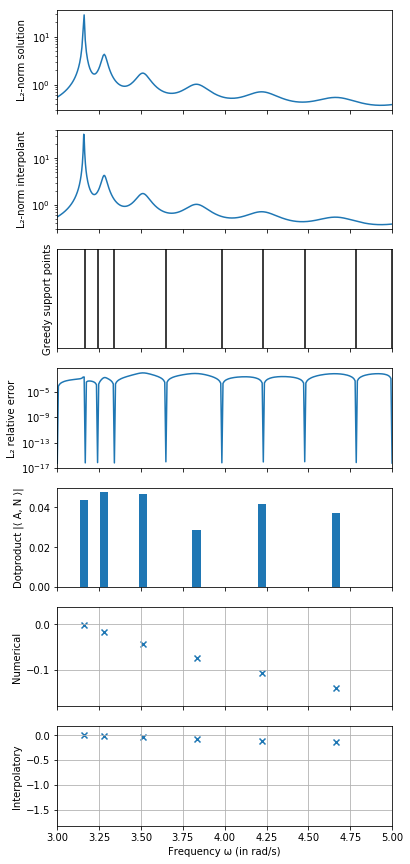

In [31]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.complex_scatter(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

/home/fenics/shared/examples/imperfect_conductor/imperfect_conductor.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  u_func.vector()[:] = u_vec


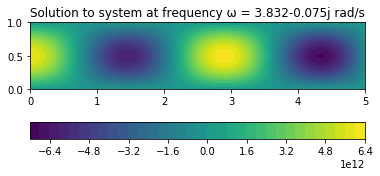

In [40]:
RC.solve(eigfreqs[:1])
sol = RC.get_solution()[0]
RC.plot_external_solution(sol, contains_boundary_values=True, omega=eigfreqs[0])

### Higher impedance

In [41]:
RC.imp = fen.Expression('10.0', degree=2)
RC.setup()

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/fenics/shared/src/time_harmonic_maxwell_problem.py:358: ComplexWarning: Casting complex values to real discards the imaginary part
  u_vec_inserted[inner_indices] = u_vec
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


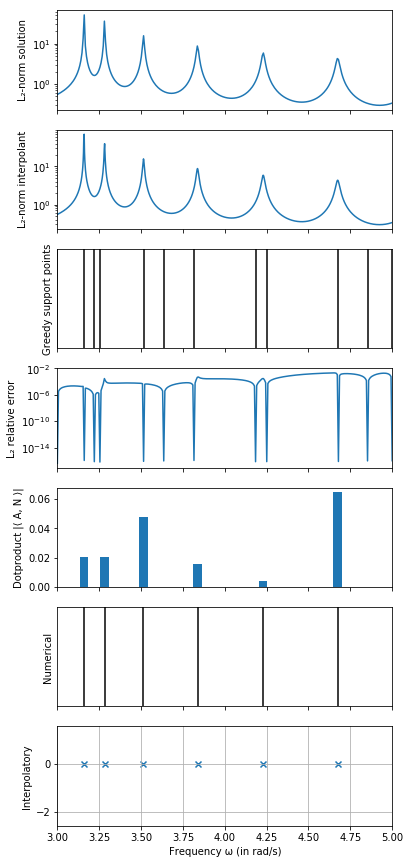

In [42]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

### Lower impedance

In [43]:
RC.imp = fen.Expression('0.1', degree=2)
RC.setup()

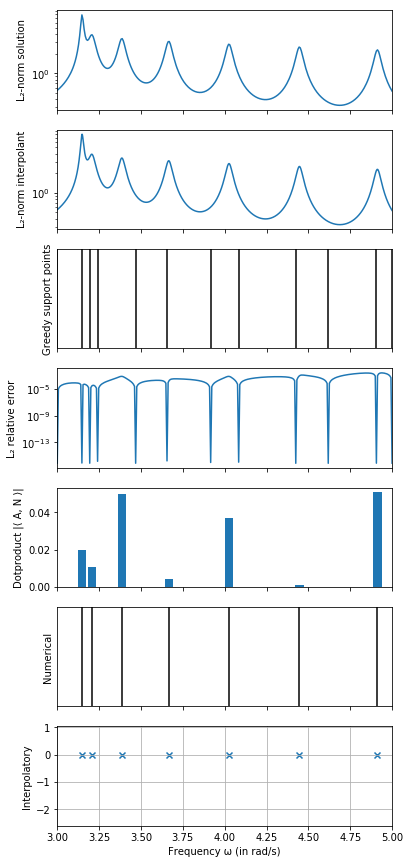

In [44]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.complex_scatter(ax[6], MRI.get_interpolatory_eigenfrequencies())

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

## Compare eigensolver to rational interpolation

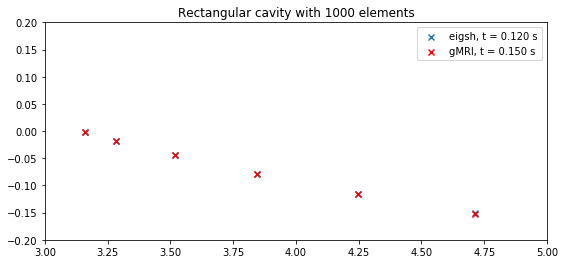

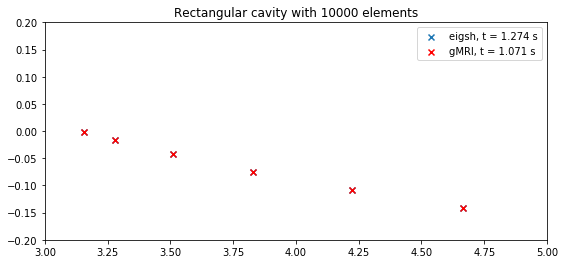

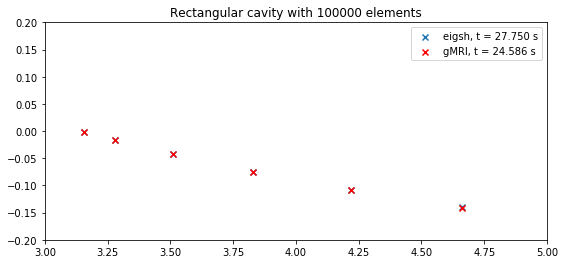

In [5]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 100)

for N in np.logspace(3, 5, 3, dtype=int):
    imp = fen.Expression('1.0', degree=2)
    RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N, imp=imp)
    RC.setup()
    VS = VectorSpaceL2(RC)
    fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharex=True)
    t0 = time.time()
    eigfreqs_FE = RC.get_numerical_eigenfrequencies(a, b)
    t_FE = time.time() - t0
    helpers.complex_scatter(ax, eigfreqs_FE, label='eigsh, t = {:.3f} s'.format(t_FE))
    t0 = time.time()
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='scipy')
    eigfreqs_RI =  MRI.get_interpolatory_eigenfrequencies()
    t_RI = time.time() - t0
    helpers.complex_scatter(ax, eigfreqs_RI, color='red', label='gMRI, t = {:.3f} s'.format(t_RI))
    ax.set_title(f'Rectangular cavity with {N} elements')
    ax.set_xlim(a, b)
    ax.set_ylim(-0.2, 0.2)
    ax.legend()
    plt.show()